In [93]:
import numpy as np
import pandas as pd

from sklearn import preprocessing

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

from sklearn.linear_model import  LogisticRegression, RidgeClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.impute import SimpleImputer

from sklearn.model_selection import learning_curve, StratifiedKFold

import matplotlib.pyplot as plt
import random

In [22]:
def plot_curve(plt1, title, xscale, ylim, train_sizes, train_scores, test_scores, xlabel):
    plt1.title.set_text(title)
    if ylim is not None:
        plt1.set_ylim(*ylim)
    plt1.set_xlabel(xlabel + ". Шкала: " + xscale)
    plt1.set_xscale(xscale)
    plt1.set_ylabel("Оценка ROC-AUC")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt1.grid()

    plt1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt1.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Оценка обучения")
    plt1.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Оценка теста")

    plt1.legend(loc="best")
    return

def plot_learning_curve(estimator, title, X, y, ylim, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc'
    )

    plot_curve(plt1, title, 'log', ylim,  train_sizes, train_scores, test_scores, 'Размер данных')  
    plot_curve(plt2, title, 'linear', ylim,  train_sizes, train_scores, test_scores, 'Размер данных')   

    return 

# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [10]:
# df_data = pd.read_csv('orange_small_churn_data.train')
# df_labels = pd.read_csv('orange_small_churn_labels.train', names=['Label'], header=None)
# df_data['Label'] = df_labels.Label

In [7]:
df_data = pd.read_csv('not_hold_out_dataset.csv')
# Удалим переменные в которых все значения NaN.
df_tmp = df_data.dropna(axis=1, how='all')
# Преобразование в лоб всех столбцов по OneHotEncoder без предварительной подготовки
# данных приводит к не подъёмному DataFrame. Поэтому для baseline решения применяем LabelEncoder.
df_object = df_tmp.copy()
columns = df_object.select_dtypes(['object']).columns
df_object[columns] = df_object[columns].astype('category')
df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)
# Заполним значения NaN средними значениями по столбцу.
X = df_object.iloc[:,:-1]
si = SimpleImputer(strategy='mean')
X = si.fit_transform(X)
# Выполнение масштабирования данных
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
# Массив с метками.
y = df_object.iloc[:,-1]

In [9]:
df_object.shape[0] /(2 * df_object['Label'].value_counts())


-1    0.540135
 1    6.728972
Name: Label, dtype: float64

In [34]:
np.logspace(-3, 0, 5)

array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])

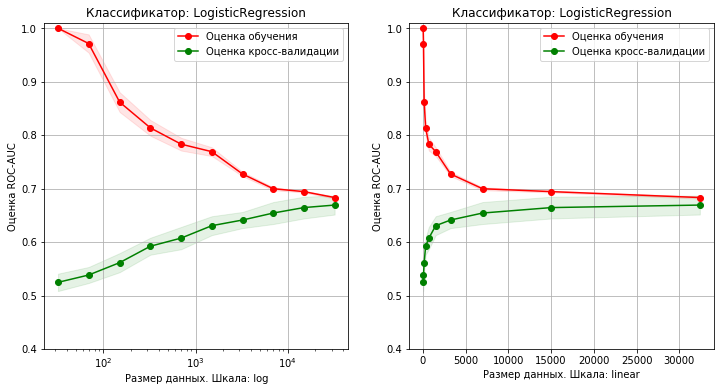

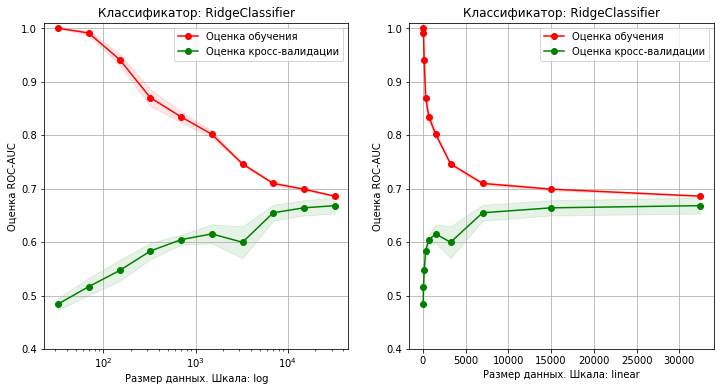

In [87]:
# est = LogisticRegression(solver='liblinear')
# est = RidgeClassifier()
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# for est in [SGDClassifier(), LogisticRegression(solver='liblinear'), RidgeClassifier(),
#             RandomForestClassifier(n_estimators=500), GradientBoostingClassifier()]:
    
for est in [  LogisticRegression(solver='liblinear'), RidgeClassifier() ]:
    cv = StratifiedKFold(n_splits=10, shuffle=True) 
    plot_learning_curve(est, 'Классификатор: ' + type(est).__name__, X, y, ylim=(0.4, 1.01), 
                    train_sizes=np.logspace(-3, 0, 10), 
                    cv=cv, n_jobs=5)
# train_sizes, train_scores, test_scores =  learning_curve(est, X, y, 
#                scoring='roc_auc', train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]), cv=3)

plt.show()

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [56]:
np.logspace(-3, 0.1, 20)[:-1]

array([0.001     , 0.00145599, 0.0021199 , 0.00308655, 0.00449398,
       0.00654319, 0.00952681, 0.01387092, 0.0201959 , 0.02940499,
       0.04281332, 0.0623357 , 0.09076005, 0.13214558, 0.19240242,
       0.28013568, 0.40787428, 0.59386019, 0.8646535 ])

In [59]:
%%time
train_score, test_score = [], []
# train_point = np.linspace(1, 10, 10) 
train_point = np.logspace(-3, 2, 20)[:-1]
cv = StratifiedKFold(n_splits=5, shuffle=True)

for cw in [{-1:1, 1:w} for w in train_point]:
    est = LogisticRegression(solver='liblinear', class_weight=cw) 
    cv_rez = cross_validate(est, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=10,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), cw)

0.5532 0.5542 {-1: 1, 1: 0.001}
0.566 0.568 {-1: 1, 1: 0.0018329807108324356}
0.5838 0.5874 {-1: 1, 1: 0.003359818286283781}
0.6065 0.6115 {-1: 1, 1: 0.006158482110660267}
0.6274 0.6339 {-1: 1, 1: 0.011288378916846888}
0.6432 0.6506 {-1: 1, 1: 0.02069138081114789}
0.6524 0.6619 {-1: 1, 1: 0.0379269019073225}
0.6589 0.6688 {-1: 1, 1: 0.06951927961775606}
0.663 0.6736 {-1: 1, 1: 0.12742749857031335}
0.6646 0.6773 {-1: 1, 1: 0.23357214690901212}
0.6676 0.6803 {-1: 1, 1: 0.42813323987193913}
0.6682 0.683 {-1: 1, 1: 0.7847599703514607}
0.6689 0.6851 {-1: 1, 1: 1.438449888287663}
0.6688 0.6868 {-1: 1, 1: 2.636650898730358}
0.6678 0.6883 {-1: 1, 1: 4.832930238571752}
0.6684 0.6888 {-1: 1, 1: 8.858667904100823}
0.6669 0.6892 {-1: 1, 1: 16.23776739188721}
0.6685 0.6885 {-1: 1, 1: 29.763514416313193}
0.6643 0.6878 {-1: 1, 1: 54.555947811685144}
Wall time: 3min 24s


In [58]:
print(cw.round(4))

AttributeError: 'dict' object has no attribute 'round'

In [60]:
cv_rez = cross_validate(LogisticRegression(solver='liblinear', class_weight='balanced'), X, y, cv=cv, 
                  return_train_score=True, 
                  return_estimator=True,
                  verbose=0, n_jobs=4,
                  scoring=('roc_auc'))

balanced_test = cv_rez['test_score'].mean()
balanced_train = cv_rez['train_score'].mean()
print(cw, cv_rez['test_score'].mean(), cv_rez['train_score'].mean())


{-1: 1, 1: 54.555947811685144} 0.6690291451367514 0.6879230917542469


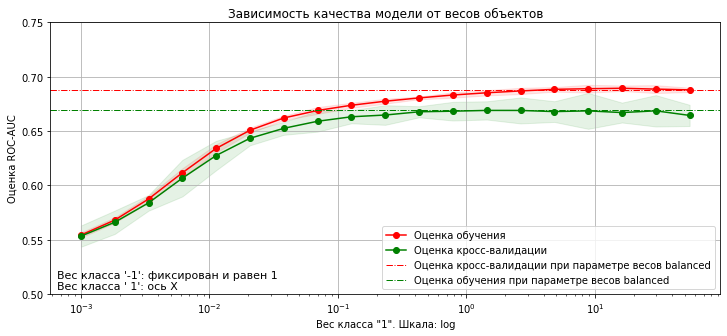

In [61]:
# fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(9, 4))
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))

plot_curve(plt1, 'Зависимость качества модели от весов объектов', 'log', 
           (0.5, .75),  train_point, train_score, test_score, 'Вес класса "1"') 
plt1.axhline(balanced_train, color='r', lw=1, ls='-.', label='Оценка кросс-валидации при параметре весов balanced') 
plt1.axhline(balanced_test, color='g', lw=1, ls='-.', label='Оценка обучения при параметре весов balanced') 
plt1.legend(loc="best")
plt1.text(0.01, 0.01, "Вес класса '-1': фиксирован и равен 1\nВес класса ' 1': ось X", 
         transform=plt1.transAxes, fontsize=11, verticalalignment='bottom')
plt.show()

In [52]:
 [w if isinstance(w, str) else {1:w, -1:(1.-w)} for w in [0.1, 0.3, 0.5, 'balanced']]

[{1: 0.1, -1: 0.9}, {1: 0.3, -1: 0.7}, {1: 0.5, -1: 0.5}, 'balanced']

In [110]:
df_object.shape[0] /(2 * df_object['Label'].value_counts())

0    0.540135
1    6.728972
Name: Label, dtype: float64

In [25]:
df_object['Label'].value_counts()

 1    2675
-1     118
Name: Label, dtype: int64

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [21]:
%%time
df_data = pd.read_csv('not_hold_out_dataset.csv')
df_data['CountNotNull'] = df_data.count(axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
columns = df_data.select_dtypes(['object']).columns

cv = StratifiedKFold(n_splits=5, shuffle=True)
train_score, test_score, train_point = [], [], []

for border in [0] + list(range(70, 79)) :
    print(border, df_object.shape)

    df_object = df_data[ ((df_data['Label'] == -1) & (df_data['CountNotNull'] > border)) | 
                        (df_data['Label'] == 1) ].copy()
    df_object[columns] = df_object[columns].astype('category')
    df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)
    X = df_object.iloc[:,:-2]
    si = SimpleImputer(strategy='mean')
    X = si.fit_transform(X)
    y = df_object.iloc[:,-2]
    print('Start cross_validate')
    est = LogisticRegression(solver='liblinear') 
    cv_rez = cross_validate(est, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=4,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    train_point.append(df_object.shape[0])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), border)


0 (2793, 233)
0 (36000, 233)
Start cross_validate
0.5988 0.6127 0
70 (36000, 233)
70 (26058, 233)
Start cross_validate
0.6533 0.6692 70
71 (26058, 233)
71 (21784, 233)
Start cross_validate
0.6553 0.6657 71
72 (21784, 233)
72 (18015, 233)
Start cross_validate
0.7019 0.7142 72
73 (18015, 233)
73 (15948, 233)
Start cross_validate
0.7193 0.7268 73
74 (15948, 233)
74 (13242, 233)
Start cross_validate
0.7093 0.7253 74
75 (13242, 233)
75 (9475, 233)
Start cross_validate
0.7525 0.7703 75
76 (9475, 233)
76 (6315, 233)
Start cross_validate
0.7324 0.7537 76
77 (6315, 233)
77 (4001, 233)
Start cross_validate
0.754 0.7728 77
78 (4001, 233)
78 (2793, 233)
Start cross_validate
0.7149 0.7965 78
Wall time: 9min 38s


In [16]:
# [26058, 21784, 18015, 15948, 13242, 9475, 6315, 4001, 2793]
[36000 - x for x in train_point]

[0, 9942, 14216, 17985, 20052, 22758, 26525, 29685, 31999, 33207]

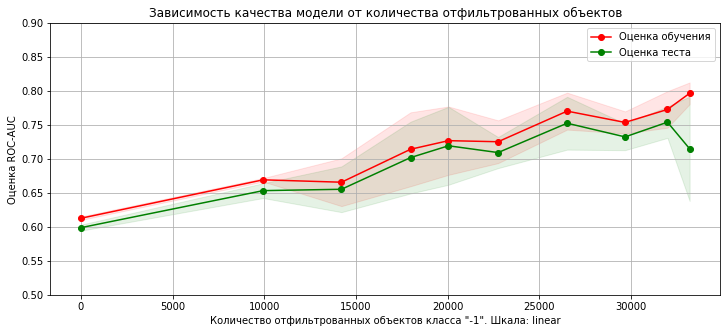

In [23]:
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))
# train_point = [26058, 21784, 18015, 15948, 13242, 9475, 6315, 4001, 2793] 
# range(70, 79)

plot_curve(plt1, 'Зависимость качества модели от количества отфильтрованных объектов', 'linear', 
           (0.5, .9),  [df_data.shape[0] - x for x in train_point], 
           train_score, test_score, 'Количество отфильтрованных объектов класса "-1"') 
plt.show()

In [12]:
train_point = [0] + list(range(70, 79)) 
train_point

[0, 70, 71, 72, 73, 74, 75, 76, 77, 78]

In [107]:
df_data[['CountNotNull', 'Label']].groupby(['CountNotNull']).agg([ 'count'])

,Label
,count
CountNotNull,
49,1
51,1
52,14
53,66
54,76
55,163
56,154
57,77


In [57]:
# np.linspace(0, df.loc[-1] - df.loc[1], 10, dtype=int)
df

-1    33325
 1     2675
Name: Label, dtype: int64

In [60]:
%%time
# Второй тип отбора строк для удаления - случайный
df_data = pd.read_csv('not_hold_out_dataset.csv')
min_max_scaler = preprocessing.MinMaxScaler()
columns = df_data.select_dtypes(['object']).columns

cv = StratifiedKFold(n_splits=5, shuffle=True)
train_score, test_score = [], []

df = df_data['Label'].value_counts()
train_point = np.linspace(0, df.loc[-1] - df.loc[1], 10, dtype=int)

l_index = list(df_data[df_data['Label'] == -1].index)

for border in train_point:
    df_object = df_data.drop( random.sample(l_index,  border) )
    print(border, df_object.shape[0])
    df_object[columns] = df_object[columns].astype('category')
    df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)
    X = df_object.iloc[:,:-1]
    si = SimpleImputer(strategy='mean')
    X = si.fit_transform(X)
    y = df_object.iloc[:,-1]
    est = LogisticRegression(solver='liblinear') 
    cv_rez = cross_validate(est, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=4,
                          scoring=('roc_auc'))
    train_score.append(cv_rez['train_score'])
    test_score.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), border)


0 36000
0.5989 0.612 0
3405 32595
0.6011 0.6135 3405
6811 29189
0.601 0.6132 6811
10216 25784
0.5974 0.6136 10216
13622 22378
0.5992 0.6143 13622
17027 18973
0.6017 0.6169 17027
20433 15567
0.5949 0.6134 20433
23838 12162
0.6054 0.619 23838
27244 8756
0.6057 0.6217 27244
30650 5350
0.6055 0.6361 30650
Wall time: 20min 11s


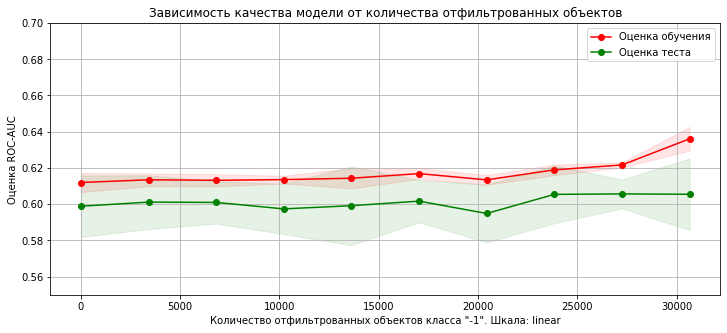

In [65]:
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))
plot_curve(plt1, 'Зависимость качества модели от количества отфильтрованных объектов', 'linear', 
           (0.55, .7),   train_point, 
           train_score, test_score, 'Количество отфильтрованных объектов класса "-1"') 
plt.show()

In [107]:
# df_data = pd.read_csv('not_hold_out_dataset.csv', index_col=0)
df_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,Label,CountNotNull
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1,62
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1,75
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1,71
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1,67
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1,70


3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [105]:
%%time
df_data = pd.read_csv('not_hold_out_dataset.csv', index_col=0)
df_data['CountNotNull'] = df_data.count(axis=1)
df_object = df_data.drop( df_data[(df_data['Label'] == -1) & (df_data['CountNotNull'] < 78 ) ].index)

columns = df_data.select_dtypes(['object']).columns
df_object[columns] = df_object[columns].astype('category')
df_object[columns] = df_object[columns].apply(lambda x: x.cat.codes)

cv = StratifiedKFold(n_splits=10, shuffle=True)
train_score3, test_score3 = [], []


train_point3 = ['mean', 'median', 'most_frequent', 'constant']
fill_values = [None, None, None, -10000000]

# min(df_object.iloc[:,:-2].min())                         
                         
for (strategy, fill_value) in zip(train_point3, fill_values):
#     print(strategy, fill_value)
    si = SimpleImputer(strategy=strategy, fill_value=fill_value)
    X = df_object.iloc[:,:-2]
    y = df_object.iloc[:,-2]
    est = LogisticRegression(solver='liblinear') 
    pipe = Pipeline([('inputer', si), ('est', est)])
    
    cv_rez = cross_validate(pipe, X, y, cv=cv, 
                          return_train_score=True, 
                          return_estimator=True,
                          verbose=0, n_jobs=4,
                          scoring=('roc_auc'))
    train_score3.append(cv_rez['train_score'])
    test_score3.append(cv_rez['test_score'])
    print(cv_rez['test_score'].mean().round(4), cv_rez['train_score'].mean().round(4), strategy)


0.7261 0.7852 mean
0.8421 0.8725 median
0.917 0.9408 most_frequent
0.9949 0.9978 constant
Wall time: 1min


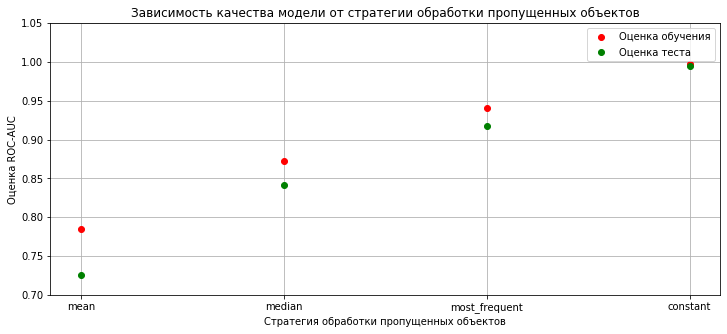

In [106]:
fig, plt1 = plt.subplots(1, 1, figsize=(12, 5))
# plot_curve(plt1, 'Зависимость качества модели от стратегии обработки пропущенных объектов', 'linear', 
#            (0.7, .95),   train_point3, 
#            train_score3, test_score3, 'Cтратегия обработки пропущенных объектов') 
plt1.title.set_text('Зависимость качества модели от стратегии обработки пропущенных объектов')
plt1.set_ylim((0.7, 1.05))
plt1.set_xlabel('Cтратегия обработки пропущенных объектов')
# plt1.set_xscale(xscale)
plt1.set_ylabel("Оценка ROC-AUC")

plt1.grid()

plt1.plot(train_point3, np.mean(train_score3, axis=1) , 'o', color="r", 
         label="Оценка обучения")
plt1.plot(train_point3, np.mean(test_score3, axis=1), 'o', color="g",
         label="Оценка теста")

plt1.legend(loc="best")


plt.show()

In [101]:
df_test.head()

,Id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,...,6,302,3,-1,0,22,1,18,-1,NaN
1,1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,...,4,577,0,-1,-1,22,2,8,-1,NaN
2,2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,...,4,173,0,-1,1,17,2,8,1,NaN
3,3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,...,4,149,3,-1,1,17,2,8,0,NaN
4,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,...,4,694,0,-1,-1,4,2,8,-1,NaN


In [108]:
df_test = pd.read_csv('orange_small_churn_test_data.csv', index_col=0)
df_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN


In [110]:
df_test = pd.read_csv('orange_small_churn_test_data.csv', index_col=0)

columns = df_test.select_dtypes(['object']).columns
df_test[columns] = df_test[columns].astype('category')
df_test[columns] = df_test[columns].apply(lambda x: x.cat.codes)

est = LogisticRegression(solver='liblinear') 
si = SimpleImputer(strategy='median', fill_value =-10000000 )
X = df_object.iloc[:,:-2]
y = df_object.iloc[:,-2]

pipe = Pipeline([('inputer', si), ('est', est)])
pipe.fit(X, y)
y_test = pipe.predict_proba(df_test)
df_test['result'] = y_test[:,1]
df_test[[ 'result']].round(2).to_csv('dminik6_part2_w3_04.csv', index=True)

C:\ProgramData\Anaconda2\envs\newpy\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 